# TSF

> Time series forecasting to approach the problem of predicting density distributions

We start simple, just taking the beginning of one simulation from one scenario
and trying to predict the end of the simulation. Only for one phase space.
The 2 dimensions of the phase space can be flattened to transform the problem
into a nominal tsf problem

In [14]:
import sys
sys.path.append('..')
from mocatml.utils import *
convert_uuids_to_indices()
from mocatml.data import *
import h5py
from tsai.basics import *
my_setup()
from fastai.callback.schedule import valley, steep
from fastai.callback.wandb import WandbCallback
import wandb

os              : Linux-4.14.312-llgrid-10ms-x86_64-with-glibc2.27
python          : 3.9.15
tsai            : 0.3.7
fastai          : 2.7.12
fastcore        : 1.5.29
torch           : 1.13.1+cu116
device          : 1 gpu (['Tesla V100-PCIE-32GB'])
cpu cores       : 40
threads per cpu : 2
RAM             : 377.58 GB
GPU memory      : N/A


In [15]:
config_base = yaml2dict('./config/base.yaml', attrdict=True)
config_tsf = yaml2dict('./config/tsf.yaml', attrdict=True)
config = AttrDict({**config_base, **config_tsf})
# Add the hyperparameters to arch.hps from the file pointed by config.arch.config_file
if config.arch.config_file is not None:
    config.arch.config_file = Path(config.arch.config_file)
    if config.arch.config_file.exists():
        config.arch.hps = yaml2dict(config.arch.config_file, attrdict=True)
    else:
        print(f'No custom arch config found in {config.arch.config_file}')
        config.arch.hps = AttrDict()
else:
    config.arch.hps = AttrDict()
config

```json
{ 'arch': {'config_file': None, 'hps': {}, 'name': 'TSiT'},
  'bs': 64,
  'data': {'path': '~/arclab_shared/density_data/TLE_density_all.mat'},
  'horizon': 1,
  'lookback': 12,
  'lr_max': None,
  'n_epoch': 25,
  'seed': 42,
  'sel_steps': None,
  'stride': 6,
  'tmp_folder': 'tmp',
  'wandb': { 'enabled': False,
             'group': None,
             'log_learner': False,
             'mode': 'offline',
             'project': 'mocatml'}}
```

In [16]:
run = wandb.init(project=config.wandb.project, 
                 config=config,
                 group=config.wandb.group,
                 mode=config.wandb.mode, 
                 anonymous='never') if config.wandb.enabled else None
config = dict2attrdict(run.config) if config.wandb.enabled else config
print(config)

{'bs': 64, 'data': {'path': '~/arclab_shared/density_data/TLE_density_all.mat'}, 'lr_max': None, 'n_epoch': 25, 'seed': 42, 'tmp_folder': 'tmp', 'wandb': {'enabled': False, 'log_learner': False, 'mode': 'offline', 'group': None, 'project': 'mocatml'}, 'arch': {'name': 'TSiT', 'config_file': None, 'hps': {}}, 'lookback': 12, 'horizon': 1, 'sel_steps': None, 'stride': 6}


In [17]:
data = h5py.File(Path(config.data.path).expanduser(), 'r')
# Remove every key starting with '__' and '#' from the dictionary   
data = {k: v for k, v in data.items() if not (k.startswith('__') or k.startswith('#'))}
print(data.keys())

dict_keys(['Am_disc', 'MCconfig', 'comb_Am_inc', 'comb_Am_ra', 'comb_Am_rp', 'comb_inc_ra', 'comb_inc_rp', 'comb_ra_rp', 'inc_disc', 'param', 'paramSSEM', 'ra_disc', 'rp_disc', 'time_density'])


In [18]:
ps_am_rp = data['comb_Am_rp'][:, :config.sel_steps] # phase space Am [m2/kg] and rp [km]
# The original data comes in the shape (n_samples, n_time_steps, Am, rp)
# Flatten the last two dimensions into one, so that the shape becomes 
# (n_samples, n_time_steps, Am*rp). Then, transpose the shape to 
# (n_samples, Am*rp, n_time_steps)
ps_am_rp = ps_am_rp.reshape(ps_am_rp.shape[0], ps_am_rp.shape[1], -1).transpose(0, 2, 1)
ps_am_rp.shape

(100, 3564, 2436)

In [19]:
# Split ps_am_rp so that different simulations are used in train and validation
splits = RandomSplitter()(ps_am_rp)
splits

((#80) [78,61,85,63,87,51,21,58,49,34...],
 (#20) [9,86,32,91,82,80,97,15,65,16...])

In [20]:
X_train, y_train = apply_sliding_window_3d(ps_am_rp[splits[0]], 
                                           window_len=config.lookback, 
                                           horizon=config.horizon, 
                                           stride=config.stride, 
                                           seq_first=False)
X_valid, y_valid = apply_sliding_window_3d(ps_am_rp[splits[1]], 
                                           window_len=config.lookback,
                                           horizon=config.horizon, 
                                           stride=config.stride,
                                           seq_first=False)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((32320, 3564, 12), (32320, 3564, 1), (8080, 3564, 12), (8080, 3564, 1))

In [21]:
X, y, splits = combine_split_data([X_train, X_valid], [y_train, y_valid])
X.shape, y.shape, splits

((40400, 3564, 12),
 (40400, 3564, 1),
 ((#32320) [0,1,2,3,4,5,6,7,8,9...],
  (#8080) [32320,32321,32322,32323,32324,32325,32326,32327,32328,32329...]))

#params: 6533362


epoch,train_loss,valid_loss,time
0,22.501497,23.578104,00:13
1,2.429770,34.007591,00:13
2,1.973127,26.777227,00:13
3,32.316067,30.920263,00:13
4,31.651434,31.233778,00:13
5,31.656851,30.684118,00:13
6,31.402309,30.710581,00:12
7,31.378403,30.529753,00:12
8,31.342237,30.545158,00:12


KeyboardInterrupt: 

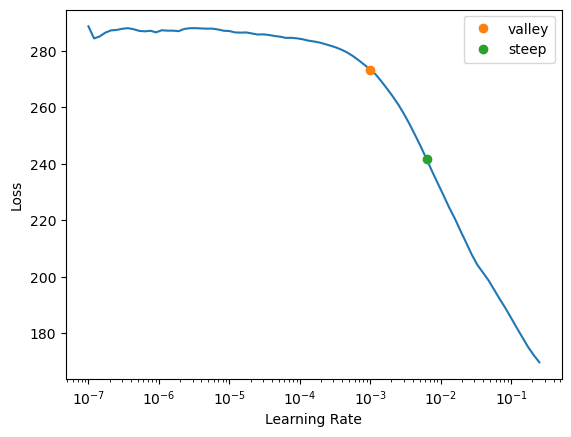

In [22]:
#batch_tfms=[TSStandardize()]
wandb_callback = WandbCallback(log_preds=False)
cbs = L(wandb_callback) if config.wandb.enabled else L()
batch_tfms=[]
learn = TSForecaster(X, y, splits, bs=[config.bs, 2*config.bs], batch_tfms=batch_tfms,
                     seed=config.seed, arch='TSiTPlus', arch_config=dict())
lr_max = learn.lr_find(suggest_funcs=(valley, steep)).steep if config.lr_max is None else config.max_lr
print(f"#params: {sum(p.numel() for p in learn.model.parameters())}")
learn.fit_one_cycle(n_epoch=config.n_epoch, lr_max=lr_max)
learn.plot_metrics()

In [ ]:
# Print the validation loss and save it in case other notebooks (optuna) wants to
# use it for hyperparameter optimization
valid_loss = learn.validate()[0] 
print(valid_loss)
%store valid_loss

In [ ]:
if config.wandb.enabled:
    learn.remove_cb(wandb_callback)

# Save locally and in wandb if online and enabled
learn.save_all(path=config.tmp_folder, verbose=True) 
if run is not None and config.wandb.log_learner:
    # Save the learner (all tmp/dls, tmp/model.pth, and tmp/learner.pkl). 
    run.log_artifact(config.tmp_folder, type='learner', name='tsf')

In [ ]:
if run is not None:
    run.finish()